<a href="https://colab.research.google.com/github/jibbsmathew/Medical-Insurance-Causal-Inference/blob/main/Medical_Insurance_Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install causalnex

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
from causalnex.structure import StructureModel
from causalnex.inference import InferenceEngine
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
data=pd.read_csv('insurance.csv')

DATA PREPROCESSING


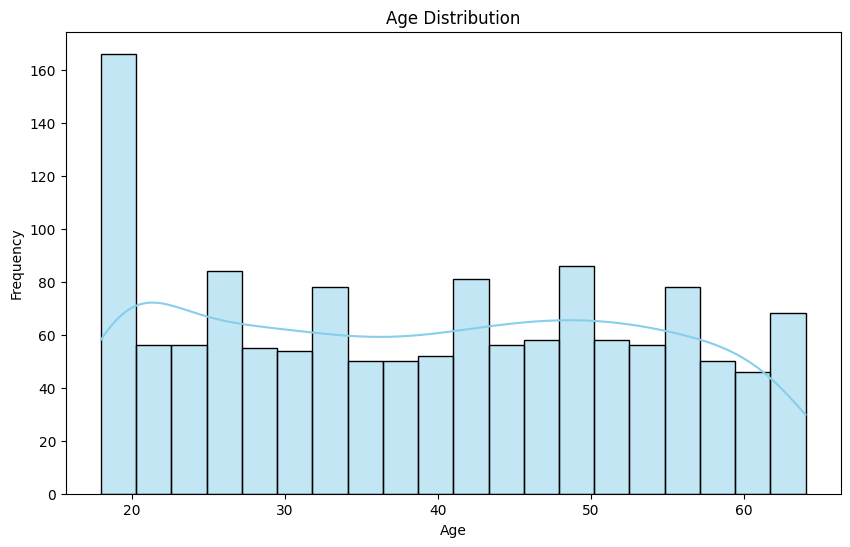

In [37]:
# Visualization 1: Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<ipython-input-33-59a31f9de5ba>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=data['sex'], y=data['bmi'], palette='pastel')


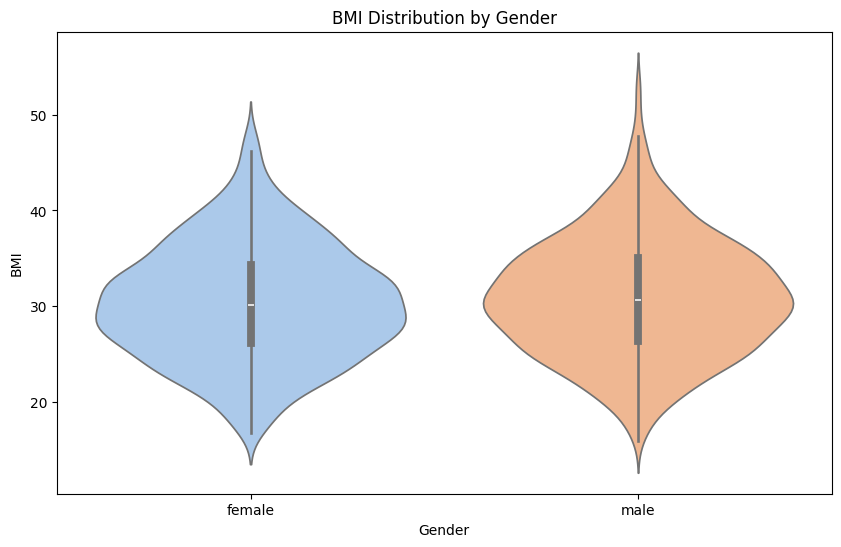

In [33]:
# Visualization 2: BMI Distribution (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(x=data['sex'], y=data['bmi'], palette='pastel')
plt.title('BMI Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('BMI')
plt.show()

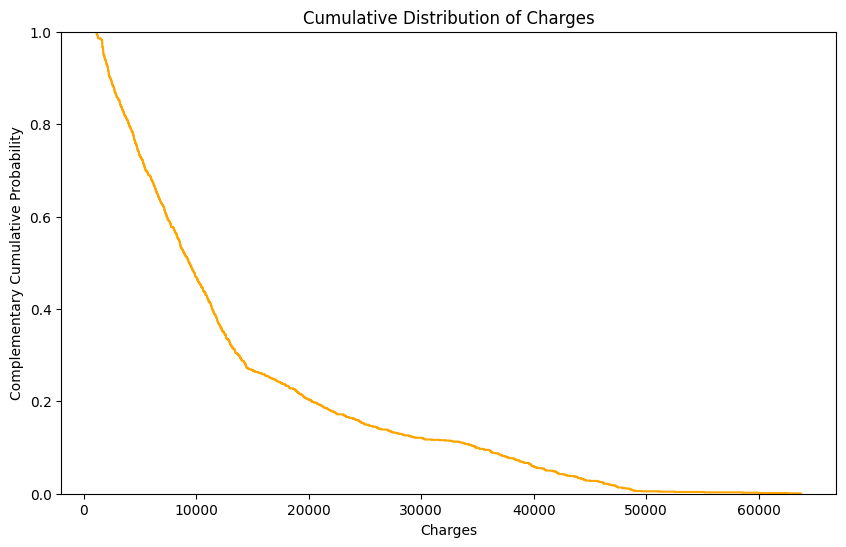

In [34]:
# Visualization 3: Distribution of Charges (ECDF Plot)
plt.figure(figsize=(10, 6))
sns.ecdfplot(data['charges'], complementary=True, color='orange')
plt.title('Cumulative Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Complementary Cumulative Probability')
plt.show()

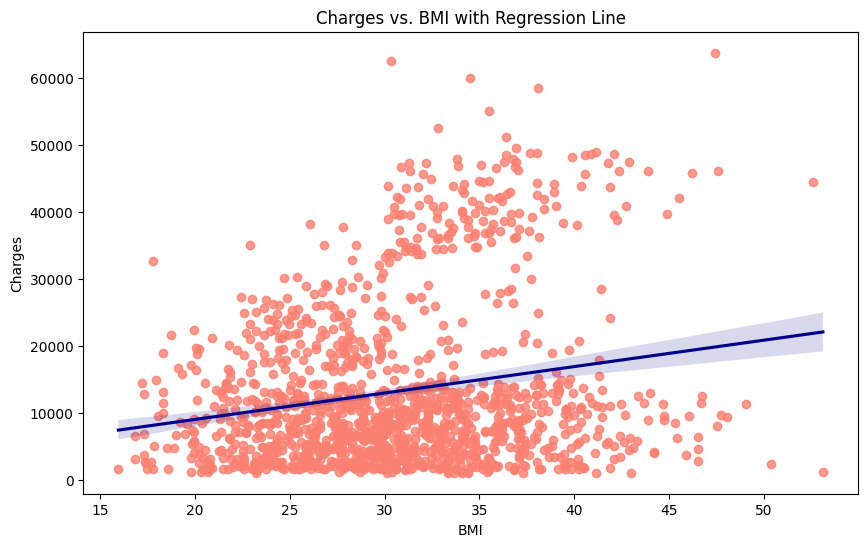

In [35]:
# Visualization 4: Charges vs. BMI Scatter Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x='bmi', y='charges', data=data, scatter_kws={'color': 'salmon'}, line_kws={'color': 'darkblue'})
plt.title('Charges vs. BMI with Regression Line')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

<ipython-input-36-30cd3c2e17fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='region', x='charges', data=data, palette='Set3')


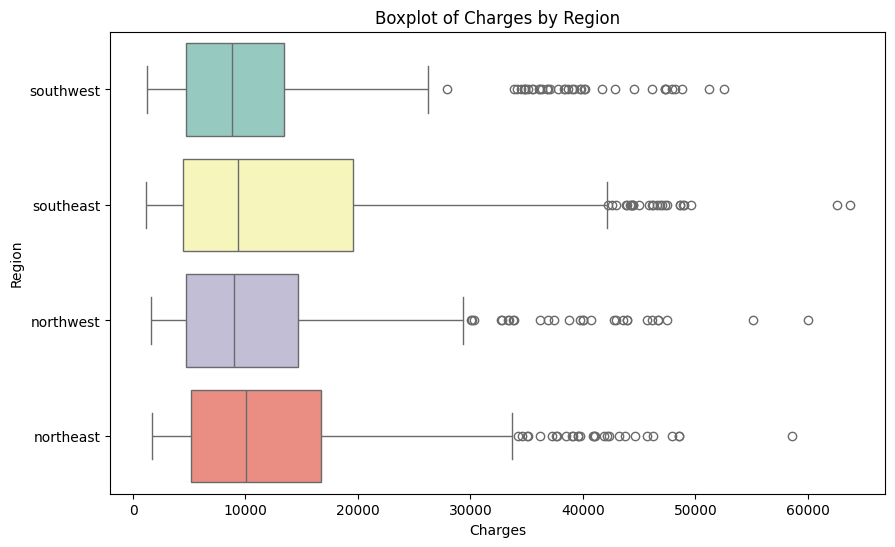

In [36]:
# Visualization 5: Boxplot of Charges by Region (Horizontal)
plt.figure(figsize=(10, 6))
sns.boxplot(y='region', x='charges', data=data, palette='Set3')
plt.title('Boxplot of Charges by Region')
plt.xlabel('Charges')
plt.ylabel('Region')
plt.show()

In [ ]:
# Visualization 2: BMI Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['bmi'], bins=20, kde=True, color='salmon')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

CAUSAL INFERENCE:

1. Randomized Controlled Trials (RCTs)

In [17]:
# 1. Randomized Controlled Trials (RCTs)
treatment_group = data[data['smoker'] == 'yes']['charges']
control_group = data[data['smoker'] == 'no']['charges']
t_stat, p_value = ttest_ind(treatment_group, control_group)
print(f'RCTs - T-Statistic: {t_stat}, P-Value: {p_value}')

RCTs - T-Statistic: 46.66492117272371, P-Value: 8.271435842179102e-283


Text(0.5, 1.0, 'RCTs - Treatment vs Control')

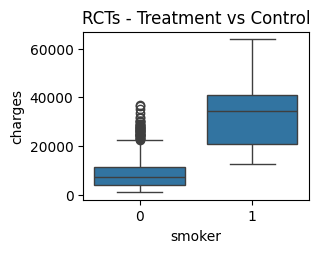

In [26]:
# RCTs Visualization
plt.subplot(2, 2, 1)
sns.boxplot(x='smoker', y='charges', data=data)
plt.title('RCTs - Treatment vs Control')

2. Instrumental Variables (IV)

In [18]:

# Convert 'charges' column to numeric
data['charges'] = pd.to_numeric(data['charges'], errors='coerce')
# Convert 'smoker' to numeric
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})

# 2. Instrumental Variables (IV)
# Assuming 'bmi' is the instrument variable
iv_model = sm.OLS(data['charges'], sm.add_constant(data[['smoker', 'bmi']])).fit()
causal_effect_iv = iv_model.params['smoker']
print(f'IV - Causal Effect: {causal_effect_iv}')


IV - Causal Effect: 23593.980998514442


Text(0.5, 1.0, 'IV - Causal Effect: 23593.98')

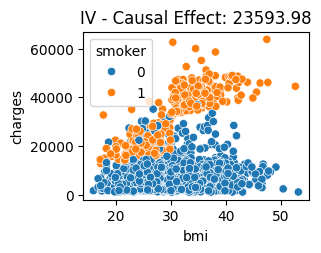

In [27]:
# IV Visualization
plt.subplot(2, 2, 2)
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=data)
plt.title(f'IV - Causal Effect: {causal_effect_iv:.2f}')

3. Propensity Score Matching

In [20]:
# Generate propensity scores using logistic regression
logreg = sm.Logit(data['smoker'], sm.add_constant(data[['age', 'bmi']]))
result = logreg.fit()
data['propensity_score'] = result.predict()

# Check for missing values in 'propensity_score'
print(data['propensity_score'].isnull().sum())

# Propensity Score Matching
treated_indices = data[data['smoker'] == 1].index
control_indices = data[data['smoker'] == 0].index

nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn.fit(data['propensity_score'].values.reshape(-1, 1))

matched_control_indices = nn.kneighbors(data.loc[treated_indices, 'propensity_score'].values.reshape(-1, 1),
                                       return_distance=False).flatten()

matched_data = pd.concat([data.loc[treated_indices], data.loc[matched_control_indices]])

# Display the matched data
print(matched_data)

Optimization terminated successfully.
         Current function value: 0.506628
         Iterations 5
0
      age     sex     bmi  children  smoker     region      charges  \
0      19  female  27.900         0       1  southwest  16884.92400   
11     62  female  26.290         0       1  southeast  27808.72510   
14     27    male  42.130         0       1  southeast  39611.75770   
19     30    male  35.300         0       1  southwest  36837.46700   
23     34  female  31.920         1       1  northeast  37701.87680   
...   ...     ...     ...       ...     ...        ...          ...   
1313   19  female  34.700         2       1  southwest  36397.57600   
1314   30  female  23.655         3       1  northwest  18765.87545   
1321   62    male  26.695         0       1  northeast  28101.33305   
1323   42  female  40.370         2       1  southeast  43896.37630   
1337   61  female  29.070         0       1  northwest  29141.36030   

      propensity_score  
0             0.21

Text(0.5, 1.0, 'Propensity Score Matching')

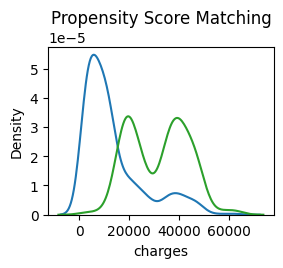

In [28]:
# Propensity Score Matching Visualization
plt.subplot(2, 2, 3)
sns.kdeplot(data['charges'], label='All Data')
sns.kdeplot(treatment_group, label='Treatment Group')
sns.kdeplot(matched_data['charges'], label='Matched Control Group')
plt.title('Propensity Score Matching')

4. Difference-in-Differences (DiD) using causalnex

In [22]:
import statsmodels.api as sm

# 4. Difference-in-Differences (DiD) using causalnex
# Assuming 'region' is the treatment variable
data['treatment'] = np.where(data['region'] == 'southwest', 1, 0)

# Creating interaction term
data['interaction_term'] = data['treatment'] * data['smoker']

# DiD regression
did_model = sm.OLS(data['charges'], sm.add_constant(data[['smoker', 'treatment', 'interaction_term']])).fit()

# Extract causal effect
causal_effect_did = did_model.params['interaction_term']
print(f'DiD - Causal Effect: {causal_effect_did}')

DiD - Causal Effect: 831.5979718961249


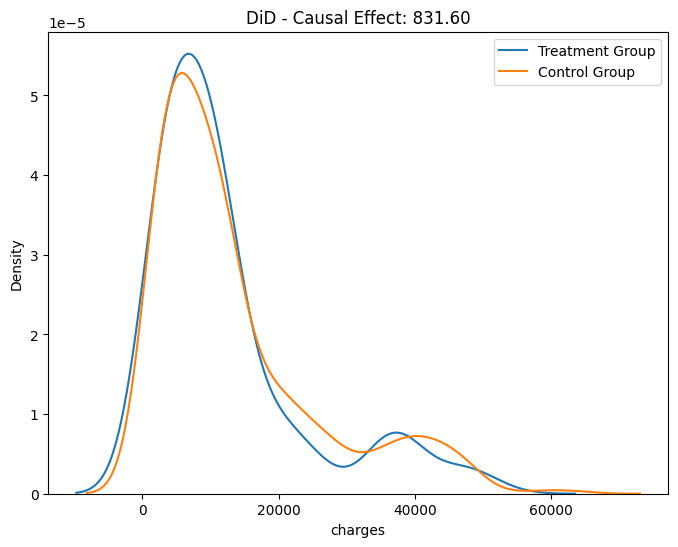

In [30]:
# Visualization
plt.figure(figsize=(8, 6))
sns.kdeplot(data[data['treatment'] == 1]['charges'], label='Treatment Group')
sns.kdeplot(data[data['treatment'] == 0]['charges'], label='Control Group')
plt.title(f'DiD - Causal Effect: {causal_effect_did:.2f}')
plt.legend()
plt.show()